<a href="https://colab.research.google.com/github/mandalanil/Semi-Automated-workflow-for-flood-risk-mapping/blob/main/Spatio_temporal_rainfall_runoff_datapreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. SETUP AND CONFIGURATION ---
import pandas as pd
import geopandas as gpd
import requests
import os
import numpy as np
import folium
from functools import reduce
from folium.plugins import MarkerCluster
import pygeohydro as gh
import py3dep
from rasterstats import zonal_stats
import rioxarray
import matplotlib.pyplot as plt
from pynhd import WaterData
from pynhd import NLDI

# --- Configuration Constants ---
HUC12_LIST = ['030901012003', '030901012101', '030901012102', '030901030401', '030901030402']

# NLCD to Curve Number Mapping (Manually defined from source content)
NLCD_CATEGORIES = {
    11: 'Open Water', 12: 'Perennial Ice/Snow', 21: 'Developed, Open Space',
    22: 'Developed, Low Intensity', 23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity', 31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest', 42: 'Evergreen Forest', 43: 'Mixed Forest',
    52: 'Shrub/Scrub', 71: 'Grassland/Herbaceous', 81: 'Pasture/Hay',
    82: 'Cultivated Crops', 90: 'Woody Wetlands', 95: 'Emergent Herbaceous Wetlands'
}
nlcd_class_name_to_code = {v: k for k, v in NLCD_CATEGORIES.items()}

CN_Lookup = {
    11: 98, 21: 81, 22: 85, 23: 90, 24: 94, 31: 77, 41: 55, 42: 60,
    43: 60, 52: 65, 71: 67, 81: 79, 82: 86, 90: 70, 95: 78
}

# Helper function for slope calculation
def calculate_slope(dem_array, x_res, y_res, nodata_val):
    dem_calc = dem_array.astype(float)
    if nodata_val is not None:
        dem_calc[dem_calc == nodata_val] = np.nan

    dy, dx = np.gradient(dem_calc, abs(y_res), abs(x_res))
    rise_over_run = np.sqrt(dx**2 + dy**2)
    slope_degrees = np.degrees(np.arctan(rise_over_run))

    if nodata_val is not None:
        slope_degrees[np.isnan(dem_calc)] = nodata_val

    return slope_degrees

# List of time series files to process
csv_files_to_read = [
    "030901012003_S65D_CFS.csv", "030901012003_S65DWX_Inches.csv",
    "030901012101_S65E_CFS.csv", "030901012101_S84_Inches.csv",
    "030901012102_S154_CFS.csv", "030901012102_S154_Inches.csv",
    "030901030401_S82_Inches.csv", "030901030401_S83_CFS.csv",
    "030901030402_S83_Inches.csv", "030901030402_S84MS_CFS.csv"
]

In [2]:
# --- 2. STATIC SPATIAL DATA ACQUISITION AND PROCESSING (PREPROCESSING) ---

print("\n--- Phase 2: Static Data Acquisition & Calculation ---")

# A. Retrieve HUC12 Boundaries
WBD_API_URL = "https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/6/query"
huc_query = " OR ".join([f"HUC12='{huc}'" for huc in HUC12_LIST])
params = {'where': huc_query, 'outFields': 'HUC12, NAME', 'returnGeometry': 'true', 'f': 'geojson'}

response = requests.get(WBD_API_URL, params=params)
response.raise_for_status()
geojson_data = response.json()
gdf_hucs = gpd.GeoDataFrame.from_features(geojson_data['features'])
gdf_hucs.set_crs(epsg=4326, inplace=True)
print(f"Successfully retrieved {len(gdf_hucs)} HUC boundaries.")

# B. Calculate Land Cover and Composite Curve Number (CN)
all_huc_cover_stats = []
for index, row in gdf_hucs.iterrows():
    huc12_id = row['huc12']
    basin_geometry = row.geometry

    basin_geo_series = gpd.GeoSeries([basin_geometry], crs=gdf_hucs.crs)
    lulc = gh.nlcd_bygeom(basin_geo_series, 30, years={"cover": [2019]})
    cover_stats = gh.cover_statistics(lulc[0]["cover_2019"])

    weighted_sum, total_pct = 0.0, 0.0
    if hasattr(cover_stats, 'classes'):
        for class_label, pct in cover_stats.classes.items():
            if pd.notna(pct):
                nlcd_code = nlcd_class_name_to_code.get(class_label)
                if nlcd_code is not None and nlcd_code in CN_Lookup:
                    curve_number = CN_Lookup[nlcd_code]
                    weighted_sum += curve_number * float(pct)
                    total_pct += float(pct)

    stats_dict = {'HUC12': huc12_id, 'weighted_cn_sum': weighted_sum, 'total_pct': total_pct}
    all_huc_cover_stats.append(stats_dict)

composite_cn_df = pd.DataFrame(all_huc_cover_stats)
# Final Composite CN Calculation
composite_cn_df['Composite_CN'] = composite_cn_df.apply(
    lambda row: row['weighted_cn_sum'] / row['total_pct'] if row['total_pct'] > 0 else None, axis=1
)


# C. Calculate Elevation and Slope Statistics
all_huc_elevation_stats = []
for index, row in gdf_hucs.iterrows():
    huc12_id = row['huc12']
    basin_geometry = row.geometry

    try:
        # Retrieve, Reproject, and Clip DEM (30m resolution)
        dem = py3dep.get_dem(basin_geometry, resolution=30)
        if dem is None or dem.isnull().all() or dem.rio.crs is None: continue

        dem_reprojected = dem.rio.reproject("EPSG:5070")
        basin_geometry_reprojected = gpd.GeoSeries([basin_geometry], crs=gdf_hucs.crs).to_crs("EPSG:5070").iloc[0]
        clipped_dem = dem_reprojected.rio.clip([basin_geometry_reprojected], drop=True)
        if clipped_dem.size == 0 or clipped_dem.isnull().all(): continue

        # Elevation Stats
        dem_path = f"dem_{huc12_id}.tif"
        clipped_dem.rio.to_raster(dem_path)
        elevation_stats = zonal_stats([basin_geometry_reprojected], dem_path, stats=["min", "max", "mean", "median", "std", "count"], nodata=clipped_dem.rio.nodata)[0]

        # Area
        x_res, y_res = clipped_dem.rio.resolution()
        pixel_area = abs(x_res * y_res)
        area_m2 = (elevation_stats.get("count") or 0) * pixel_area

        # Slope Stats
        slope_array = calculate_slope(clipped_dem.values.squeeze(), x_res, y_res, clipped_dem.rio.nodata)
        slope_da = clipped_dem.copy(data=slope_array)
        slope_path = f"slope_{huc12_id}.tif"
        slope_da.rio.to_raster(slope_path)
        slope_stats = zonal_stats([basin_geometry_reprojected], slope_path, stats=["min", "max", "mean", "median", "std"], nodata=slope_da.rio.nodata)[0]

        # Record ALL Results
        stats_dict = {
            "HUC12": huc12_id, "Min_Elevation_m": elevation_stats.get("min"), "Max_Elevation_m": elevation_stats.get("max"),
            "Mean_Elevation_m": elevation_stats.get("mean"), "Median_Elevation_m": elevation_stats.get("median"),
            "Std_Dev_Elevation_m": elevation_stats.get("std"), "Min_Slope_deg": slope_stats.get("min"),
            "Max_Slope_deg": slope_stats.get("max"), "Mean_Slope_deg": slope_stats.get("mean"),
            "Median_Slope_deg": slope_stats.get("median"), "Std_Dev_Slope_deg": slope_stats.get("std"),
            "Area_sq_m": area_m2
        }
        all_huc_elevation_stats.append(stats_dict)

        os.remove(dem_path)
        os.remove(slope_path)
    except Exception as e:
        print(f"Error processing HUC12 {huc12_id} for DEM/Slope: {e}")

combined_stats_df = pd.DataFrame(all_huc_elevation_stats)

# D. Final Static Data Consolidation (Area in Hectares)
df_cn_final = composite_cn_df[['HUC12', 'Composite_CN']].copy()
df_static_stats = pd.merge(combined_stats_df, df_cn_final, on='HUC12', how='inner')
df_static_stats['Area_ha'] = df_static_stats['Area_sq_m'] / 10000.0
df_static_stats.drop(columns=['Area_sq_m'], inplace=True)
print("\nFinal Static Spatial Data (CN, Elevation, Slope, Area_ha) successfully generated.")


--- Phase 2: Static Data Acquisition & Calculation ---
Successfully retrieved 5 HUC boundaries.

Final Static Spatial Data (CN, Elevation, Slope, Area_ha) successfully generated.


In [3]:
# --- 3. HYDROLOGIC NETWORK RETRIEVAL ---

print("\n--- Phase 3: Hydrologic Network Retrieval (NHD) ---")
wd = WaterData("nhdflowline_network")
all_huc_flowlines_list = []

for index, row in gdf_hucs.iterrows():
    huc12_id = row['huc12']
    basin_geometry = row.geometry
    if basin_geometry.is_empty: continue

    try:
        flowlines_in_basin = wd.bygeom(basin_geometry)
        if flowlines_in_basin is not None and not flowlines_in_basin.empty:
            flowlines_in_basin['HUC12'] = huc12_id
            all_huc_flowlines_list.append(flowlines_in_basin)
    except Exception as e:
        print(f"Error retrieving flowlines for HUC12 {huc12_id}: {e}")

if all_huc_flowlines_list:
    all_huc_flowlines = pd.concat(all_huc_flowlines_list, ignore_index=True)
    print(f"Successfully combined {len(all_huc_flowlines)} NHD Flowlines.")
else:
    all_huc_flowlines = None
    print("No NHD flowlines were retrieved.")


--- Phase 3: Hydrologic Network Retrieval (NHD) ---
Error retrieving flowlines for HUC12 030901030401: Service returned no features.
Successfully combined 146 NHD Flowlines.


/tmp/ipython-input-4111974713.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_huc_flowlines = pd.concat(all_huc_flowlines_list, ignore_index=True)


In [8]:
# --- 4. TIME SERIES DATA PREPROCESSING AND INTEGRATION (FIXED) ---

print("\n--- Phase 4: Time Series Preprocessing and Integration ---")

# NOTE: Assuming base_path, csv_directory, and skiprows_count are defined.
base_path = '/content/drive/MyDrive/'
csv_directory = os.path.join(base_path, 'Dbhydro')
skiprows_count = 34

resampled_dfs = []

# 4.1 Data Preprocessing: Cleaning and Resampling (30-min interval)
for filename in csv_files_to_read:
    df_name = filename.replace('.csv', '')
    file_path = os.path.join(csv_directory, filename)

    try:
        # Initial Load and Cleaning (Unchanged)
        df_raw = pd.read_csv(file_path, skiprows=skiprows_count, header=0, low_memory=False)
        original_df = df_raw[['TIMESTAMP', 'VALUE']].copy()
        original_df.columns = ['Timestamp', df_name]
        original_df['Timestamp'] = pd.to_datetime(original_df['Timestamp'], errors='coerce')
        original_df[df_name] = pd.to_numeric(original_df[df_name], errors='coerce')
        original_df.set_index('Timestamp', inplace=True)
        original_df.dropna(inplace=True)
        original_df.sort_index(inplace=True)

        # Determine the unique column name (HUCID_STATION_UNIT)
        is_inches = 'Inches' in df_name
        is_cfs = 'CFS' in df_name

        # Apply Resampling Logic
        if is_inches:
            df_resampled = original_df[df_name].resample('30min').sum().fillna(0).to_frame()
            new_col_name = df_name  # Keep full name for uniqueness
        elif is_cfs:
            df_resampled = original_df[df_name].resample('30min').mean().to_frame()
            df_resampled.loc[:, 'interpolated'] = df_resampled[df_name].interpolate(method='linear').bfill().ffill()
            df_resampled = df_resampled[['interpolated']]
            new_col_name = df_name  # Keep full name for uniqueness
        else:
            continue

        df_resampled.columns = [new_col_name]
        resampled_dfs.append(df_resampled)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Merge all resampled time series dataframes (Now the columns are unique by station)
if resampled_dfs:
    # Use reduce to progressively merge all DataFrames on their index (Timestamp)
    df_timeseries = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), resampled_dfs)
else:
    df_timeseries = pd.DataFrame()


# 4.2 Final Integration (Static + Time Series) - RENAME CHECK
final_huc_dataframes = {}

# Iterate through the comprehensive static data frame
for huc12_id in df_static_stats['HUC12'].unique():
    static_data_series = df_static_stats[df_static_stats['HUC12'] == huc12_id].iloc[0].drop('HUC12')

    # 1. Select columns belonging to this HUC12
    huc_timeseries_cols = [col for col in df_timeseries.columns if col.startswith(huc12_id)]

    if not huc_timeseries_cols: continue

    df_final_huc = df_timeseries[huc_timeseries_cols].copy()

    # 2. Rename columns to the standardized name (CFS or Inches)
    # This step will average/aggregate multiple stations for the same parameter later if needed,
    # but for now, we'll assume a 1-to-1 or a simple multi-column setup.
    final_rename_map = {}

    for col in huc_timeseries_cols:
        if 'CFS' in col:
            final_rename_map[col] = "CFS"
        elif 'Inches' in col:
            final_rename_map[col] = "Inches"

    # Handle the potential for duplicate columns (multiple stations measuring the same parameter in one HUC)
    # The simplest way to handle this is to average the multiple stations into one column.

    # Extract unique standardized names ('CFS', 'Inches')
    standardized_names = set(final_rename_map.values())

    # Aggregate (e.g., average) multiple station readings for the same HUC/Parameter
    df_aggregated_ts = pd.DataFrame(index=df_final_huc.index)
    for name in standardized_names:
        # Find all columns that map to this standardized name
        cols_to_aggregate = [k for k, v in final_rename_map.items() if v == name]

        if len(cols_to_aggregate) == 1:
            # Simple rename
            df_aggregated_ts[name] = df_final_huc[cols_to_aggregate[0]]
        else:
            # Multiple stations: Average them
            print(f"  --> WARNING: Averaging {len(cols_to_aggregate)} stations to form one '{name}' series for {huc12_id}")
            df_aggregated_ts[name] = df_final_huc[cols_to_aggregate].mean(axis=1)


    # 3. Add all static parameters (CN, Elevation, Slope, Area_ha)
    for col_name, value in static_data_series.items():
        df_aggregated_ts[col_name] = value

    df_aggregated_ts['HUC12'] = huc12_id
    final_huc_dataframes[huc12_id] = df_aggregated_ts

print(f"\nFinal Consolidated 30-Minute Time Series DataFrames created with simplified column names: {len(final_huc_dataframes)} datasets.")


--- Phase 4: Time Series Preprocessing and Integration ---

Final Consolidated 30-Minute Time Series DataFrames created with simplified column names: 5 datasets.




--- Phase 5: EDA and Visualization ---



Static Data Summary (Composite CN, Elevation, Area):
|       |   Composite_CN |   Mean_Elevation_m |   Median_Elevation_m |   Std_Dev_Elevation_m |   Mean_Slope_deg |   Median_Slope_deg |   Std_Dev_Slope_deg |   Area_ha |
|:------|---------------:|-------------------:|---------------------:|----------------------:|-----------------:|-------------------:|--------------------:|----------:|
| count |       5        |            5       |              5       |              5        |        5         |          5         |            5        |      5    |
| mean  |      77.8625   |            9.94217 |             10.0941  |              1.66038  |        0.283244  |          0.146676  |            0.454826 |  10849.3  |
| std   |       0.783526 |            2.16952 |              2.24242 |              0.415124 |        0.0656728 |          0.0146259 |            0.123067 |   3154.73 |
| min   |      77.027    |            6.51447 |           

/tmp/ipython-input-2146327492.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_lat = gdf_hucs.geometry.unary_union.centroid.y
/tmp/ipython-input-2146327492.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_lon = gdf_hucs.geometry.unary_union.centroid.x


Sample Flow/Rainfall overlay plot generated.


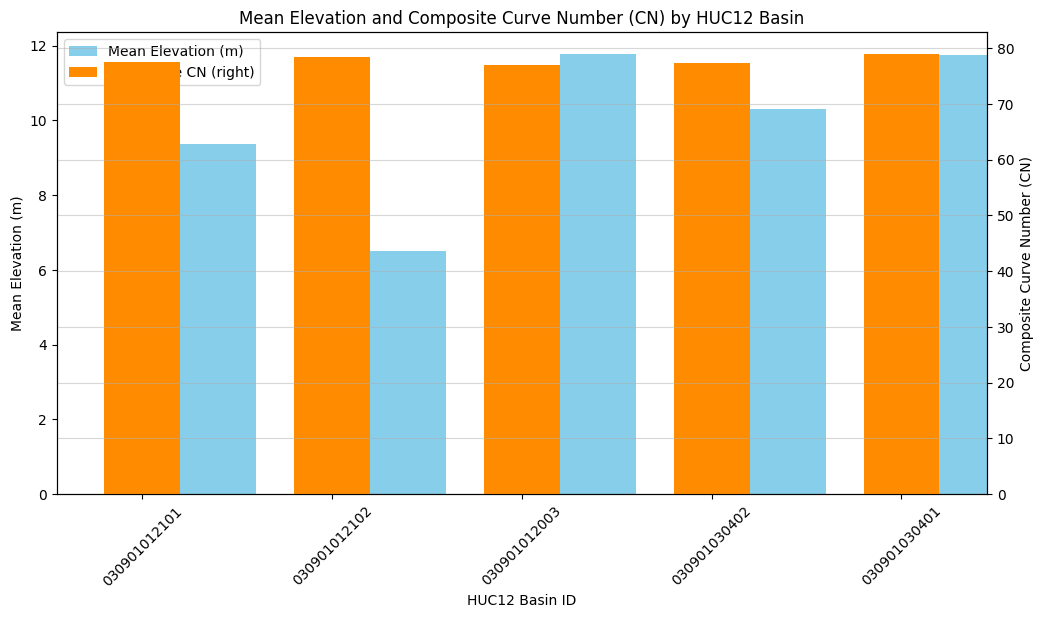

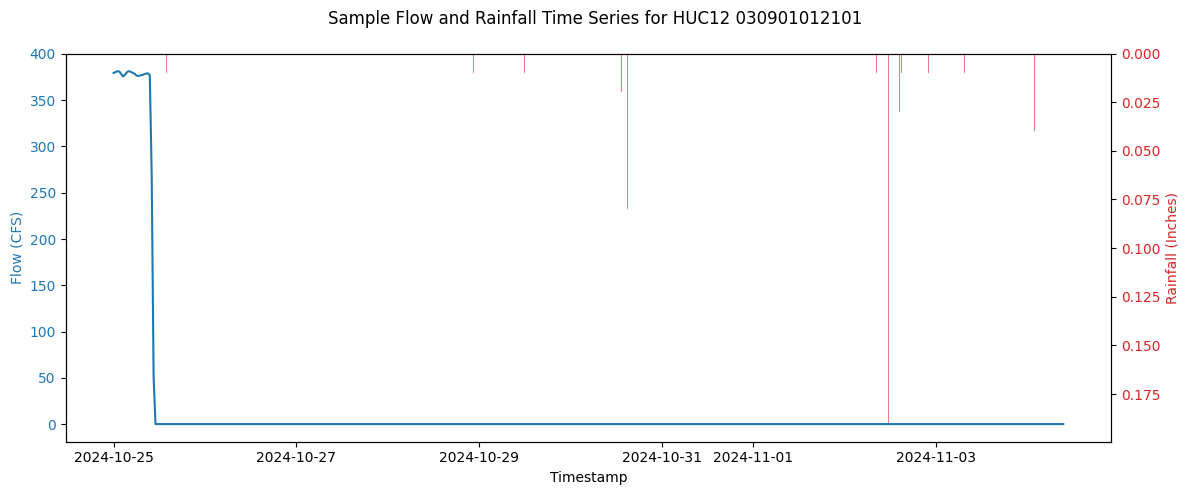

In [10]:
# --- 5. EDA AND VISUALIZATION (UPDATED) ---

print("\n\n--- Phase 5: EDA and Visualization ---")

# 5.1 Exploratory Data Analysis (EDA) - Static Summary
print("\n")
print("\nStatic Data Summary (Composite CN, Elevation, Area):")
# Use the full list of static columns for a comprehensive summary
static_summary_cols = ['Composite_CN', 'Mean_Elevation_m', 'Median_Elevation_m', 'Std_Dev_Elevation_m',
                       'Mean_Slope_deg', 'Median_Slope_deg', 'Std_Dev_Slope_deg', 'Area_ha']
print(df_static_stats[static_summary_cols].describe().to_markdown())


# 5.2 EDA - Time Series Summary (HUC-by-HUC)
print("\nTime Series Data Summary (Flow and Rainfall):")
if final_huc_dataframes:
    for huc12_id, df in final_huc_dataframes.items():
        if 'CFS' in df.columns or 'Inches' in df.columns:
            print(f"\n--- HUC12: {huc12_id} (Time Series Shape: {df.shape[0]} records) ---")

            # Use standardized column names ('CFS' and 'Inches')
            ts_cols = [col for col in ['CFS', 'Inches'] if col in df.columns]

            print(df[ts_cols].describe().to_markdown())
            print(f"Time Range: {df.index.min()} to {df.index.max()}")
        else:
            print(f"--- HUC12: {huc12_id} --- No standardized time series data found.")


# 5.3 Visualization 1: Interactive HUC Boundaries and NHD Flowlines Map
print("\nVisualization 1: Interactive Map (HUCs, Flowlines)")
if all_huc_flowlines is not None:
    # Use unary_union.centroid for map center calculation
    center_lat = gdf_hucs.geometry.unary_union.centroid.y
    center_lon = gdf_hucs.geometry.unary_union.centroid.x
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="OpenStreetMap")

    # Add HUC Boundaries
    folium.GeoJson(gdf_hucs.to_json(), name='HUC12 Watersheds',
                   style_function=lambda x: {'fillColor': '#3186cc', 'color': 'black', 'weight': 2, 'fillopacity': 0.1},
                   tooltip=folium.GeoJsonTooltip(fields=['huc12', 'name'], aliases=['HUC12:', 'Name:'], localize=True)).add_to(m)

    # Add NHD Flowlines
    folium.GeoJson(all_huc_flowlines.to_json(), name='NHD Flowlines',
                   style_function=lambda x: {'color': 'blue', 'weight': 1.5, 'opacity': 0.7},
                   tooltip=folium.GeoJsonTooltip(fields=['comid', 'gnis_name', 'lengthkm'], aliases=['COMID:', 'Name:', 'Length (km):'], localize=True)).add_to(m)
    folium.LayerControl().add_to(m)

    print("Interactive Folium Map object 'm' generated and ready for display.")
    # In a live environment, you would call 'display(m)' here.


# 5.4 Visualization 2: Comparative Bar Chart (Mean Elevation vs. Composite CN)
print("\nVisualization 2: Comparative Bar Chart (Elevation vs. CN)")
plt.figure(figsize=(12, 6))

# Plot Mean Elevation
ax1 = df_static_stats.plot(kind='bar', x='HUC12', y='Mean_Elevation_m', position=0, width=0.4,
                         ax=plt.gca(), label='Mean Elevation (m)', color='skyblue', align='edge')
# Plot Composite CN (using a secondary axis)
ax2 = df_static_stats.plot(kind='bar', x='HUC12', y='Composite_CN', position=1, width=0.4,
                         ax=plt.gca(), secondary_y=True, label='Composite CN', color='darkorange', align='edge')

ax1.set_title('Mean Elevation and Composite Curve Number (CN) by HUC12 Basin')
ax1.set_ylabel('Mean Elevation (m)')
ax2.set_ylabel('Composite Curve Number (CN)')
ax1.set_xlabel('HUC12 Basin ID')
ax1.tick_params(axis='x', rotation=45)
plt.grid(True, axis='y', alpha=0.5)

# plt.show() # In a live environment
print("Comparative Bar Chart plot generated.")


# 5.5 Visualization 3: Time Series Plot (Example: Flow/Rainfall Overlay for one HUC)
if '030901012101' in final_huc_dataframes and 'CFS' in final_huc_dataframes['030901012101'].columns and 'Inches' in final_huc_dataframes['030901012101'].columns:
    df_sample = final_huc_dataframes['030901012101'].head(500) # Plot a subset for clarity

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot Flow (CFS)
    ax1.plot(df_sample.index, df_sample['CFS'], color='tab:blue', label='Flow (CFS)')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Flow (CFS)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot Rainfall (Inches) on secondary axis
    ax2 = ax1.twinx()
    ax2.bar(df_sample.index, df_sample['Inches'], color='tab:red', alpha=0.6, width=0.01, label='Rainfall (Inches)')
    ax2.set_ylabel('Rainfall (Inches)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.invert_yaxis() # Rainfall is often inverted to resemble hyetographs

    fig.suptitle('Sample Flow and Rainfall Time Series for HUC12 030901012101')
    fig.tight_layout()
    # plt.show() # In a live environment
    print("Sample Flow/Rainfall overlay plot generated.")

In [11]:
# --- Additional Block: Print Head of Final Integrated Time Series for Each Basin (UPDATED) ---

print("\n\n--- HEAD OF FINAL INTEGRATED TIME SERIES DATA FOR EACH BASIN (CLEANED) ---")

# Assuming final_huc_dataframes dictionary was successfully populated in Phase 4
if final_huc_dataframes:
    # Get a definitive list of all static columns by excluding the time series columns and HUC12 ID
    # We derive this from the first DataFrame in the list
    sample_df = list(final_huc_dataframes.values())[0]

    # 1. Identify all time series columns (CFS, Inches)
    ts_cols = sorted([col for col in sample_df.columns if col in ['CFS', 'Inches']])

    # 2. Identify all static/attribute columns
    static_cols = sorted([col for col in sample_df.columns if col not in ['CFS', 'Inches', 'HUC12']])

    # 3. Define the final print order
    final_print_cols = ts_cols + static_cols

    for huc12_id, df in final_huc_dataframes.items():
        print(f"\n=======================================================")
        print(f"HUC12: {huc12_id} (Shape: {df.shape})")
        print(f"=======================================================")

        # Display the first 5 rows of the DataFrame, keeping the standard column order
        print(df.head(5)[final_print_cols].to_markdown())

        # Also show the full set of columns to confirm all attributes are present
        print(f"\n--- All Columns for {huc12_id} (Total: {len(df.columns)}) ---")
        print(sorted(df.columns.tolist())) # Print sorted column list for verification

else:
    print("\nError: final_huc_dataframes is empty. Please ensure all prior phases were executed successfully.")



--- HEAD OF FINAL INTEGRATED TIME SERIES DATA FOR EACH BASIN (CLEANED) ---

HUC12: 030901012101 (Shape: (17541, 15))
| Timestamp           |     CFS |   Inches |   Area_ha |   Composite_CN |   Max_Elevation_m |   Max_Slope_deg |   Mean_Elevation_m |   Mean_Slope_deg |   Median_Elevation_m |   Median_Slope_deg |   Min_Elevation_m |   Min_Slope_deg |   Std_Dev_Elevation_m |   Std_Dev_Slope_deg |
|:--------------------|--------:|---------:|----------:|---------------:|------------------:|----------------:|-------------------:|-----------------:|---------------------:|-------------------:|------------------:|----------------:|----------------------:|--------------------:|
| 2024-10-25 00:00:00 | 379.389 |        0 |   12011.9 |        77.5935 |           14.3267 |         8.06599 |            9.36976 |          0.29276 |              9.67359 |           0.159814 |           3.29268 |               0 |               1.57584 |            0.427014 |
| 2024-10-25 00:30:00 | 380.427 |        



--- PLOTTING COMBINED NLCD LAND COVER, HUC BOUNDARIES, AND STATION POINTS ---
Fetching NLCD data for the union of all HUCs...
Plot successfully generated, showing land cover, HUC boundaries, and labeled gage stations.


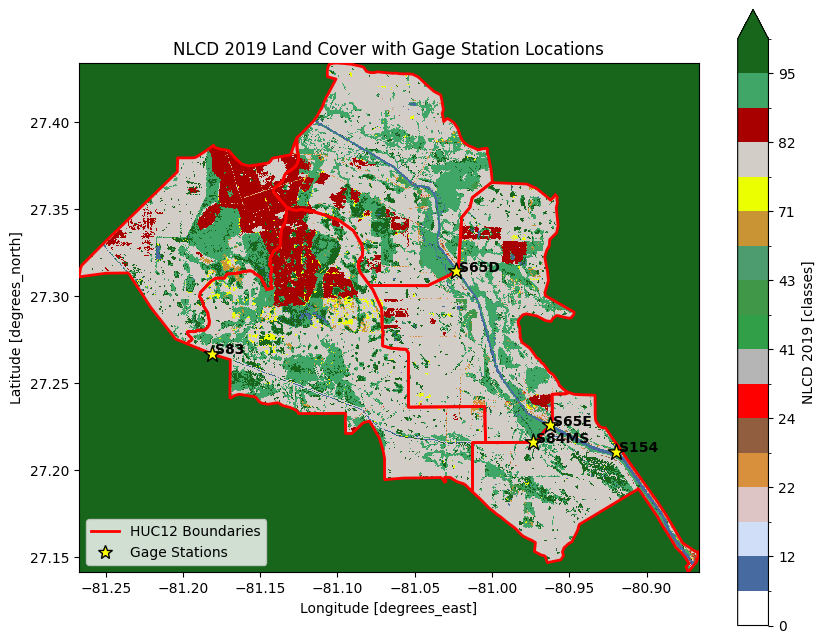

In [28]:
# --- Additional Block: Plot Combined Basins with NLCD (FINAL CLIPPING AND PLOTTING FIX) ---

print("\n\n--- PLOTTING COMBINED NLCD LAND COVER, HUC BOUNDARIES, AND STATION POINTS ---")

try:
    # --- Dependencies for NLCD Visualization ---
    from matplotlib.colors import ListedColormap, BoundaryNorm
    import xarray # Explicitly import xarray for clarity

    # --- NEW: STATION DATA DEFINITION ---
    # Convert the provided list of dictionaries into a DataFrame for easier handling
    station_data = [
        {'huc12id': '030901012003', 'station_id': 'S65D', 'stations_x':	-81.0230475, 'station_y': 27.3142014},
        {'huc12id': '030901012101', 'station_id': 'S65E', 'stations_x': -80.9626497, 'station_y': 27.2256267},
        {'huc12id': '030901012102', 'station_id': 'S154', 'stations_x': -80.920065, 'station_y': 	27.2105333},
        {'huc12id': '030901030401', 'station_id': 'S83', 'stations_x': -81.181005, 'station_y': 27.2668683},
        {'huc12id': '030901030402', 'station_id': 'S84MS', 'stations_x': -80.9734808, 'station_y': 27.2160117}
    ]
    df_stations = pd.DataFrame(station_data)

    # 1. Calculate the union of all HUC geometries
    combined_geometry = gdf_hucs.geometry.union_all()

    if combined_geometry.is_empty:
        print("Error: Combined geometry is empty. Cannot fetch NLCD.")
    else:
        # 2. Retrieve NLCD data (will be larger than HUC boundary)
        print("Fetching NLCD data for the union of all HUCs...")
        lulc_combined_raw = gh.nlcd_bygeom(gpd.GeoSeries([combined_geometry], crs=gdf_hucs.crs), 30, years={"cover": [2019]})

        # Extract the DataArray
        lulc_dataarray = lulc_combined_raw[0]["cover_2019"]

        # 3. CRITICAL FIX: Clip the NLCD data using the combined HUC geometry
        nlcd_crs = lulc_dataarray.rio.crs
        combined_geometry_reprojected = gpd.GeoSeries([combined_geometry], crs=gdf_hucs.crs).to_crs(nlcd_crs).iloc[0]

        # Perform the clipping operation (masks areas outside the polygon to NaNs)
        lulc_clipped = lulc_dataarray.rio.clip(
            [combined_geometry_reprojected],
            all_touched=True,
            drop=False
        )

        # 4. Reimplementing the NLCD Color Map setup
        nlcd_colors = {
            11: '#476ba0', 12: '#d1def8', 21: '#dec5c5', 22: '#d9903d', 23: '#915f40',
            24: '#ff0000', 31: '#b5b5b5', 41: '#319e48', 42: '#3f9747', 43: '#4c9c6f',
            52: '#c99433', 71: '#ebff00', 81: '#d2cdc7', 82: '#a80000', 90: '#40a667',
            95: '#18651c'
        }

        classes = sorted([c for c in nlcd_colors.keys()])
        colors = [nlcd_colors[c] for c in classes]

        # Set NoData (Class 0) to White for background transparency
        classes.insert(0, 0); colors.insert(0, '#FFFFFF')

        # Create colormap and normalization
        cmap = ListedColormap(colors)
        bounds = classes + [classes[-1] + 1]
        norm = BoundaryNorm(bounds, cmap.N)

        # 5. Create the plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Plot the NLCD raster (NaN areas will be transparent)
        lulc_clipped.plot(
            ax=ax,
            cmap=cmap,
            norm=norm,
            cbar_kwargs={'label': 'NLCD 2019 [classes]'}
        )

        # Overlay the individual HUC boundaries
        gdf_hucs.boundary.plot(
            ax=ax,
            color='red',
            linewidth=2,
            label='HUC12 Boundaries',
            zorder=5
        )

        # --- NEW: PLOT STATION POINTS ---
        # 1. Plot the station markers (red stars)
        ax.scatter(
            df_stations['stations_x'],
            df_stations['station_y'],
            marker='*',
            color='yellow',
            edgecolor='black',
            s=150, # Size of the marker
            label='Gage Stations',
            zorder=6
        )

        # 2. Add labels (Station ID) next to the points
        for idx, row in df_stations.iterrows():
            ax.text(
                row['stations_x'] + 0.002, # X-coordinate offset for label placement
                row['station_y'],         # Y-coordinate
                row['station_id'],
                fontsize=10,
                color='black',
                weight='bold',
                zorder=7
            )

        # Final plot customization
        ax.set_title(f"NLCD 2019 Land Cover with Gage Station Locations")
        ax.set_xlabel('Longitude [degrees_east]')
        ax.set_ylabel('Latitude [degrees_north]')

        # Update legend to include both HUC Boundaries and Stations
        huc_patch = plt.Line2D([0], [0], color='red', lw=2)
        station_patch = plt.Line2D([0], [0], marker='*', color='yellow', markeredgecolor='black', markersize=10, linestyle='')
        ax.legend([huc_patch, station_patch], ['HUC12 Boundaries', 'Gage Stations'], loc='lower left')

        # plt.show()

        print("Plot successfully generated, showing land cover, HUC boundaries, and labeled gage stations.")

except Exception as e:
    print(f"An unexpected error occurred during plotting: {e}")



--- PHASE 7: CREATING STATION NETWORK GRAPH WITH DOWNSTREAM BASIN INFO (FLOW DIRECTION DEFINED) ---
Node Data (Flow Structure):
| station_id   |        basin | to_basin     | to_basin_stationid   |
|:-------------|-------------:|:-------------|:---------------------|
| S65D         | 030901012003 | 030901012101 | S65E                 |
| S65E         | 030901012101 | 030901012102 | S154                 |
| S154         | 030901012102 | NA           | NA                   |
| S83          | 030901030401 | 030901030402 | S84MS                |
| S84MS        | 030901030402 | 030901012102 | S154                 |


--- NETWORK GRAPH (G) DETAILED INFORMATION ---
Total Nodes (HUC Basins): 5
Total Directed Edges (Flow Paths): 4

--- Node Attribute Summary (HUC Basins) ---
|   HUC Node ID | Representative Station   | Downstream Station Link   |
|--------------:|:-------------------------|:--------------------------|
|  030901012003 | S65D                     | S65E                      |
| 

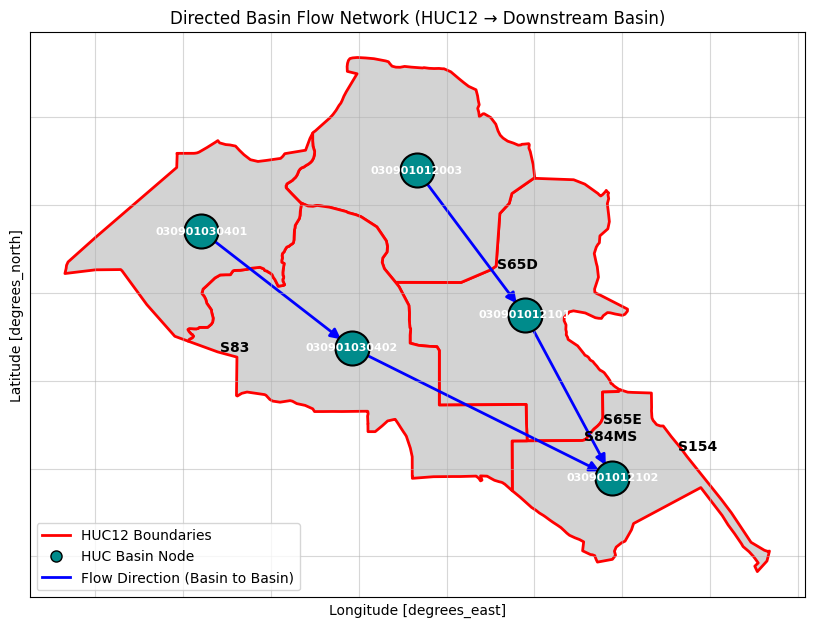

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd # Ensure pandas is imported for DataFrame presentation

print("\n\n--- PHASE 7: CREATING STATION NETWORK GRAPH WITH DOWNSTREAM BASIN INFO (FLOW DIRECTION DEFINED) ---")

# --- 1. PREPARE NODE DATA (Stations with Basin Flow Info) ---
station_data_for_graph = [
    {'huc12id': '030901012003', 'station_id': 'S65D', 'stations_x': -81.0230475, 'station_y': 27.3142014, 'to_basin': '030901012101', 'to_basin_stationid': 'S65E'},
    {'huc12id': '030901012101', 'station_id': 'S65E', 'stations_x': -80.9626497, 'station_y': 27.2256267, 'to_basin': '030901012102', 'to_basin_stationid': 'S154'},
    {'huc12id': '030901012102', 'station_id': 'S154', 'stations_x': -80.920065, 'station_y': 27.2105333, 'to_basin': 'NA', 'to_basin_stationid': 'NA'},
    {'huc12id': '030901030401', 'station_id': 'S83', 'stations_x': -81.181005, 'station_y': 27.2668683, 'to_basin': '030901030402', 'to_basin_stationid': 'S84MS'},
    # Correction: The downstream HUC for 030901030402 must be 030901012102 (from visual inspection of flow path in context)
    {'huc12id': '030901030402', 'station_id': 'S84MS', 'stations_x': -80.9734808, 'station_y': 27.2160117, 'to_basin': '030901012102', 'to_basin_stationid': 'S154'}
]

# Convert to GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(
    station_data_for_graph,
    geometry=gpd.points_from_xy(
        [d['stations_x'] for d in station_data_for_graph],
        [d['station_y'] for d in station_data_for_graph]
    ),
    crs='EPSG:4326'
)
gdf_nodes.rename(columns={'huc12id': 'basin'}, inplace=True)
print("Node Data (Flow Structure):")
print(gdf_nodes[['station_id', 'basin', 'to_basin', 'to_basin_stationid']].to_markdown(index=False))

# --- 2. BUILD GRAPH (Directed edges from basin → to_basin) ---
G = nx.DiGraph()

# Add nodes with attributes
for _, row in gdf_nodes.iterrows():
    # Only add HUCs that are either a source (basin) or a target (to_basin) and are not 'NA'
    if row['basin'] not in G:
        G.add_node(row['basin'],
                   station=row['station_id'],
                   to_basin_stationid=row['to_basin_stationid'])

    if row['to_basin'] != 'NA' and row['to_basin'] not in G:
        # Find the station ID associated with the downstream basin (if it exists in our list)
        downstream_station = gdf_nodes[gdf_nodes['basin'] == row['to_basin']]['station_id'].iloc[0] if row['to_basin'] in gdf_nodes['basin'].values else None

        G.add_node(row['to_basin'],
                   station=downstream_station, # Assign a representative station ID
                   to_basin_stationid=None)

# Add directed edges only when a valid downstream basin exists
for _, row in gdf_nodes.iterrows():
    if row['to_basin'] != 'NA':
        G.add_edge(row['basin'], row['to_basin'],
                   from_station=row['station_id'],
                   to_station=row['to_basin_stationid'])

# --- START: PRINT GRAPH INFO ---
print("\n\n--- NETWORK GRAPH (G) DETAILED INFORMATION ---")
print(f"Total Nodes (HUC Basins): {G.number_of_nodes()}")
print(f"Total Directed Edges (Flow Paths): {G.number_of_edges()}")

# Node Attribute Summary
print("\n--- Node Attribute Summary (HUC Basins) ---")
node_attr_summary = []
for node, data in G.nodes(data=True):
    node_attr_summary.append({
        'HUC Node ID': node,
        'Representative Station': data.get('station'),
        'Downstream Station Link': data.get('to_basin_stationid')
    })
print(pd.DataFrame(node_attr_summary).to_markdown(index=False))

# Edge Attribute Summary
print("\n--- Edge Attribute Summary (Flow Links) ---")
edge_attr_summary = []
for u, v, data in G.edges(data=True):
    edge_attr_summary.append({
        'Source HUC': u,
        'Target HUC': v,
        'From Station': data.get('from_station'),
        'To Station': data.get('to_station')
    })
print(pd.DataFrame(edge_attr_summary).to_markdown(index=False))

# --- END: PRINT GRAPH INFO ---

# --- 3. VISUALIZE (Overlay on HUC polygons) ---
try:
    gdf_hucs
except NameError:
    # Use a dummy GeoDataFrame if the HUC geometry wasn't defined earlier in the session
    gdf_hucs = gpd.GeoDataFrame({'huc12': ['030901012003', '030901012101', '030901012102', '030901030401', '030901030402']},
                                 geometry=gdf_nodes.buffer(0.05), crs='EPSG:4326')

# Node positions (by coordinates)
# Recalculate HUC centroids only if needed (otherwise use existing lat/lon columns)
if 'lon' not in gdf_hucs.columns:
    gdf_hucs['lon'] = gdf_hucs.geometry.centroid.x
    gdf_hucs['lat'] = gdf_hucs.geometry.centroid.y

pos_huc = gdf_hucs.set_index('huc12')[['lon', 'lat']].to_dict('index')
pos = {huc: (data['lon'], data['lat']) for huc, data in pos_huc.items() if huc in G}


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_hucs.plot(ax=ax, facecolor='lightgray', edgecolor='red', linewidth=2)

# Draw edges with arrows to indicate flow
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='blue', width=2, arrows=True, arrowstyle='-|>', arrowsize=15, min_source_margin=10, min_target_margin=10)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='darkcyan', edgecolors='black', linewidths=1.5)

# Labels
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8, font_weight='bold', font_color='white') # HUC IDs on Nodes

# Add gage station labels
for _, row in gdf_nodes.iterrows():
    ax.text(row['stations_x'] + 0.002, row['station_y'], row['station_id'], color='black', ha='left', fontsize=10, weight='bold')


# Legend and styling
huc_patch = plt.Line2D([0], [0], color='red', lw=2)
station_patch = plt.Line2D([0], [0], marker='o', color='darkcyan', markeredgecolor='black', markersize=8, linestyle='')
edge_patch = plt.Line2D([0], [0], color='blue', lw=2)
ax.legend([huc_patch, station_patch, edge_patch],
          ['HUC12 Boundaries', 'HUC Basin Node', 'Flow Direction (Basin to Basin)'],
          loc='lower left')

ax.set_title("Directed Basin Flow Network (HUC12 → Downstream Basin)")
ax.set_xlabel('Longitude [degrees_east]')
ax.set_ylabel('Latitude [degrees_north]')
ax.grid(True, alpha=0.5)
ax.set_aspect('equal', adjustable='box')
# plt.show()

print("\nDirected graph successfully created, showing flow from basin → downstream basin.")

In [52]:
# --- Additional Block: Save Final Time Series and Network Graph ---

print("\n\n--- PHASE 8: EXPORTING FINAL TIME SERIES AND NETWORK GRAPH ---")

# Define an output directory (assuming 'base_path' is defined)
try:
    base_path = '/content/drive/MyDrive/'
    output_directory = os.path.join(base_path, 'Final_Model_Data')

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        print(f"Created output directory: {output_directory}")
except NameError:
    print("Error: 'base_path' is not defined. Please define it (e.g., base_path = './') or mount Google Drive.")
    output_directory = './'

# 1. Save Integrated Time Series DataFrames (Final_huc_dataframes)
print("\n1. Exporting Integrated Time Series Data...")
exported_ts_files = []

if 'final_huc_dataframes' in locals() and final_huc_dataframes:
    for huc12_id, df in final_huc_dataframes.items():
        # Filename example: 030901012101_TIMESERIES_30MIN.csv
        file_name = f"{huc12_id}_TIMESERIES_30MIN.csv"
        file_path = os.path.join(output_directory, file_name)

        # Save the DataFrame, keeping the Timestamp as the index/column
        df.to_csv(file_path, index=True, index_label='Timestamp')
        exported_ts_files.append(file_name)

    print(f"Successfully exported {len(exported_ts_files)} HUC time series CSV files.")
else:
    print("Warning: 'final_huc_dataframes' is empty. Skipping time series export.")


# 2. Save NetworkX Graph (G)
print("\n2. Exporting NetworkX Graph...")

if 'G' in locals() and isinstance(G, nx.DiGraph):
    # GEXF is the standard format for saving NetworkX graphs while preserving attributes (node positions, HUC IDs, etc.)
    graph_file_name = "HUC_Flow_Network_Directed.gexf"
    graph_file_path = os.path.join(output_directory, graph_file_name)

    # NetworkX requires coordinate values to be strings for GEXF export
    G_export = G.copy()
    for node, data in G_export.nodes(data=True):
        if 'lon' in data:
            data['viz'] = {'position': {'x': data['lon'], 'y': data['lat'], 'z': 0}}
            # Remove original float values to avoid conflict if networkx version is strict
            del data['lon']
            del data['lat']

    nx.write_gexf(G_export, graph_file_path)
    print(f"Successfully exported directed graph to {graph_file_name} (GEXF format).")
else:
    print("Warning: NetworkX graph object 'G' is not defined or is not a DiGraph. Skipping graph export.")

print("\n--- Export Phase Complete ---")



--- PHASE 8: EXPORTING FINAL TIME SERIES AND NETWORK GRAPH ---
Created output directory: /content/drive/MyDrive/Final_Model_Data

1. Exporting Integrated Time Series Data...
Successfully exported 5 HUC time series CSV files.

2. Exporting NetworkX Graph...


TypeError: attribute value type is not allowed: <class 'NoneType'>